<h1><b>Predicting Tags for Stack Overflow Questions</b></h1>

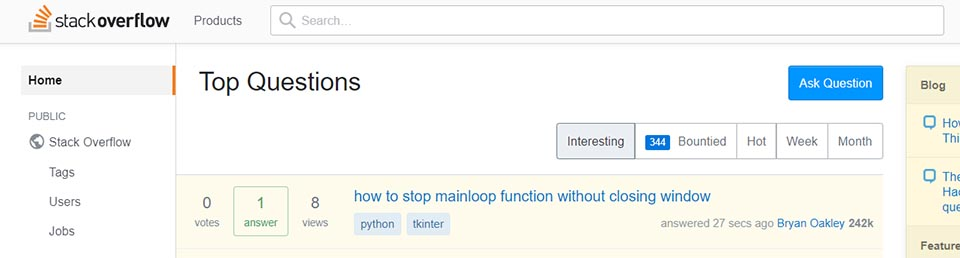

<h2><b>1. Introduction</b></h2>

*   In the expansive landscape of programming, developers worldwide rely on platforms like Stack Overflow for insights, solutions, and collaboration. With its vast repository of questions spanning diverse topics, Stack Overflow serves as a cornerstone of support for the developer community. However, as the volume of questions continues to grow, manual tagging becomes increasingly burdensome and prone to errors.

*   To address this challenge, we delve into the realm of machine learning to automate the tagging process on Stack Overflow questions. Our goal is to develop a predictive model capable of suggesting relevant tags for new inquiries, enhancing searchability and user experience. Through this notebook, we embark on a journey to explore data preprocessing, feature engineering, model selection, and evaluation, ultimately aiming to empower developers with an efficient and accurate tagging system. Join us as we harness the power of machine learning to enrich knowledge sharing and collaboration within the Stack Overflow community.

<h4><b>Find the complete code, dataset and Reference by <a href="https://drive.google.com/drive/folders/19fKEdJLikmDe6p7nbcfMBzYsejW5tvJF?usp=sharing">CLICKING HERE</a></b></h4>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Importing all required Libraries and Modules

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import re
import warnings
warnings.filterwarnings("ignore")

from collections import Counter

import os
import random
import time

import dask.dataframe as dd
from InstructorEmbedding import INSTRUCTOR

from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MultiLabelBinarizer

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout, BatchNormalization

import tensorflow as tf
from tensorflow.keras import layers, models
import keras

In [ ]:
!git clone https://github.com/HKUNLP/instructor-embedding

In [ ]:
!pip install -r /content/instructor-embedding/requirements.txt

In [ ]:
!pip install InstructorEmbedding

<h2><b>2. About the Dataset</b></h2>

<h4><b>Download the Dataset by  <a href="https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/input"><b>CLICKING HERE</b></a></b></h4>

<ul>
<li><strong>Question Dataset (question.csv):</strong>
   <ul>
     <li>Columns: 'Id', 'OwnerUserId', 'CreationDate', 'ClosedDate', 'Score', 'Title', 'Body'</li>
   </ul>
</li>

<li><strong>Answer Dataset (answer.csv):</strong>
   <ul>
     <li>Columns: 'Id', 'OwnerUserId', 'CreationDate', 'ParentId', 'Score', 'Body'</li>
   </ul>
</li>

<li><strong>Tags Dataset (tags.csv):</strong>
   <ul>
     <li>Columns: 'Id', 'Tag'</li>
   </ul>
</li>
</ul>

<ul>
    <li><strong>QuestionId:</strong> A unique identifier for each question on Stack Overflow.</li>
    <li><strong>OwnerUserId:</strong> The user ID of the individual who posted the question.</li>
    <li><strong>CreationDate:</strong> The timestamp indicating when the question was posted.</li>
    <li><strong>ParentId:</strong> For answers, this column references the ID of the question being answered.</li>
    <li><strong>Score:</strong> The score assigned to the question or answer by community members, reflecting its quality or relevance.</li>
    <li><strong>Title:</strong> The title of the question, providing a concise overview of its content.</li>
    <li><strong>Body:</strong> The body of the question, containing detailed information and context.</li>
    <li><strong>Tag:</strong> The tag(s) associated with the question, providing categorization and aiding in searchability.</li>
  </ul>

<h2><b>3. Approaches For Feature Engineering</b></h2>

<ul>
    <li><strong>Data Selection:</strong> You selected important features from three datasets: Id, Title, Body, and Tags.</li>
    <li><strong>Data Sampling:</strong> You randomly sampled 100,000 datapoints from the selected features.</li>
    <li><strong>Text Preprocessing:</strong> You cleaned and preprocessed the Title and Body columns, likely including steps such as tokenization and lowercasing.</li>
    <li><strong>Word Embedding:</strong> You converted the preprocessed text data into vector arrays using pre-trained word embeddings, specifically using an embedding with a dimension of 768.</li>
    <li><strong>Tag Filtering:</strong> You filtered tags based on their frequency, keeping only those tags that occur more than 50 times in the dataset.</li>
    <li><strong>Multi-label Binarization:</strong> You used a MultiLabelBinarizer to convert the selected tags into a binary matrix representation suitable for multi-label classification, resulting in 262 unique tags.</li>
</ul>

In [ ]:
question_df = pd.read_csv('Datasets/Questions.csv', encoding="ISO-8859-1")
question_df.head()

<div>
<style scoped>
    .dataframe tbody tr th:only-of-type {
        vertical-align: middle;
    }

    .dataframe tbody tr th {
        vertical-align: top;
    }

    .dataframe thead th {
        text-align: right;
    }
</style>
<table border="1" class="dataframe">
  <thead>
    <tr style="text-align: right;">
      <th></th>
      <th>Id</th>
      <th>OwnerUserId</th>
      <th>CreationDate</th>
      <th>ClosedDate</th>
      <th>Score</th>
      <th>Title</th>
      <th>Body</th>
    </tr>
  </thead>
  <tbody>
    <tr>
      <th>0</th>
      <td>80</td>
      <td>26.0</td>
      <td>2008-08-01T13:57:07Z</td>
      <td>NaN</td>
      <td>26</td>
      <td>SQLStatement.execute() - multiple queries in o...</td>
      <td>&lt;p&gt;I've written a database generation script i...</td>
    </tr>
    <tr>
      <th>1</th>
      <td>90</td>
      <td>58.0</td>
      <td>2008-08-01T14:41:24Z</td>
      <td>2012-12-26T03:45:49Z</td>
      <td>144</td>
      <td>Good branching and merging tutorials for Torto...</td>
      <td>&lt;p&gt;Are there any really good tutorials explain...</td>
    </tr>
    <tr>
      <th>2</th>
      <td>120</td>
      <td>83.0</td>
      <td>2008-08-01T15:50:08Z</td>
      <td>NaN</td>
      <td>21</td>
      <td>ASP.NET Site Maps</td>
      <td>&lt;p&gt;Has anyone got experience creating &lt;strong&gt;...</td>
    </tr>
    <tr>
      <th>3</th>
      <td>180</td>
      <td>2089740.0</td>
      <td>2008-08-01T18:42:19Z</td>
      <td>NaN</td>
      <td>53</td>
      <td>Function for creating color wheels</td>
      <td>&lt;p&gt;This is something I've pseudo-solved many t...</td>
    </tr>
    <tr>
      <th>4</th>
      <td>260</td>
      <td>91.0</td>
      <td>2008-08-01T23:22:08Z</td>
      <td>NaN</td>
      <td>49</td>
      <td>Adding scripting functionality to .NET applica...</td>
      <td>&lt;p&gt;I have a little game written in C#. It uses...</td>
    </tr>
  </tbody>
</table>
</div>

In [ ]:
answer_df = pd.read_csv('Datasets/Answers.csv', encoding="ISO-8859-1")
answer_df.head()

,Id,OwnerUserId,CreationDate,ParentId,Score,Body
0,92,61.0,2008-08-01T14:45:37Z,90,13,"<p><a href=""http://svnbook.red-bean.com/"">Vers..."
1,124,26.0,2008-08-01T16:09:47Z,80,12,<p>I wound up using this. It is a kind of a ha...
2,199,50.0,2008-08-01T19:36:46Z,180,1,<p>I've read somewhere the human eye can't dis...
3,269,91.0,2008-08-01T23:49:57Z,260,4,"<p>Yes, I thought about that, but I soon figur..."
4,307,49.0,2008-08-02T01:49:46Z,260,28,"<p><a href=""http://www.codeproject.com/Article..."


In [ ]:
tags_df = pd.read_csv('Datasets/tags.csv', encoding="ISO-8859-1")
tags_df.head()

,Id,Tag
0,80,flex
1,80,actionscript-3
2,80,air
3,90,svn
4,90,tortoisesvn


In [ ]:
# Concatenate 'question_df', 'answer_df', and 'tags_df' based on the 'id' and 'body' columns
merged_df = question_df.merge(answer_df, on=['Id', 'Body'], how='left').merge(tags_df, on=['Id'], how='left')

# Display the merged DataFrame
merged_df.head()

,Id,OwnerUserId_x,CreationDate_x,ClosedDate,Score_x,Title,Body,OwnerUserId_y,CreationDate_y,ParentId,Score_y,Tag
0,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,NaN,NaN,NaN,NaN,flex
1,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,NaN,NaN,NaN,NaN,actionscript-3
2,80,26.0,2008-08-01T13:57:07Z,NaN,26,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,NaN,NaN,NaN,NaN,air
3,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,NaN,NaN,NaN,NaN,svn
4,90,58.0,2008-08-01T14:41:24Z,2012-12-26T03:45:49Z,144,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,NaN,NaN,NaN,NaN,tortoisesvn


In [ ]:
final_df = merged_df[['Id', 'Title', 'Body', 'Tag']]
final_df

,Id,Title,Body,Tag
0,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,flex
1,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,actionscript-3
2,80,SQLStatement.execute() - multiple queries in o...,<p>I've written a database generation script i...,air
3,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,svn
4,90,Good branching and merging tutorials for Torto...,<p>Are there any really good tutorials explain...,tortoisesvn
...,...,...,...,...
3750989,40143360,How to fire function after v-model change?,<p>I have input which I use to filter my array...,javascript
3750990,40143360,How to fire function after v-model change?,<p>I have input which I use to filter my array...,vue.js
3750991,40143380,npm run mocha test - files being cached,<p>I'm running a mocha test and I noticed my c...,npm
3750992,40143380,npm run mocha test - files being cached,<p>I'm running a mocha test and I noticed my c...,mocha


<h2><b>4. EDA (Exploratory DataAnalysis)</b></h2>

In [ ]:
final_df.shape

(3750994, 4)

In [ ]:
final_df.isnull().sum()

Id          0
Title       0
Body        0
Tag      1113
dtype: int64

In [ ]:
final_df.duplicated().sum()

1

In [ ]:
title_count = Counter(list(final_df['Title']))
title_count.most_common(10)

[('Uncaught TypeError: undefined is not a function', 20),
 ('Input string was not in a correct format', 15),
 ('No mapping found for HTTP request with URI', 13),
 ('Query Optimization', 11),
 ('WCF Service Throttling', 10),
 ('Git post-receive hook not working', 10),
 ('undefined reference to', 10),
 ('Conversion failed when converting date and/or time from character string',
  10),
 ('Validation of viewstate MAC failed', 9),
 ('Database Normalization', 9)]

In [ ]:
final_df[final_df['Title']=='Uncaught TypeError: undefined is not a function'].head()

,Id,Title,Body,Tag
1746491,20574750,Uncaught TypeError: undefined is not a function,<p>Hi everyone i'm currently a student working...,javascript
1746492,20574750,Uncaught TypeError: undefined is not a function,<p>Hi everyone i'm currently a student working...,html
2024401,23524180,Uncaught TypeError: undefined is not a function,<p>I have Uncaught TypeError: undefined is not...,javascript
2024402,23524180,Uncaught TypeError: undefined is not a function,<p>I have Uncaught TypeError: undefined is not...,jquery
2024403,23524180,Uncaught TypeError: undefined is not a function,<p>I have Uncaught TypeError: undefined is not...,jquery-mobile


In [ ]:
body_count = Counter(list(final_df['Body']))
body_count.most_common(10)

In [ ]:
print(f"Unique Tags are : {final_df['Tag'].unique()}")
print(f"The total no of unique tags : {len(final_df['Tag'].unique())}")

Unique Tags are : ['flex' 'actionscript-3' 'air' ... 'union-types' 'voce' 'docker-windows']
The total no of unique tags : 37035


The most frequent Tags are: 
[('javascript', 124155), ('java', 115212), ('c#', 101186), ('php', 98808), ('android', 90659), ('jquery', 78542), ('python', 64601), ('html', 58976), ('c++', 47591), ('ios', 47009), ('mysql', 42464), ('css', 42308), ('sql', 35782), ('asp.net', 29970), ('objective-c', 26922), ('ruby-on-rails', 25789), ('.net', 24059), ('c', 23238), ('iphone', 21539), ('angularjs', 20345)]


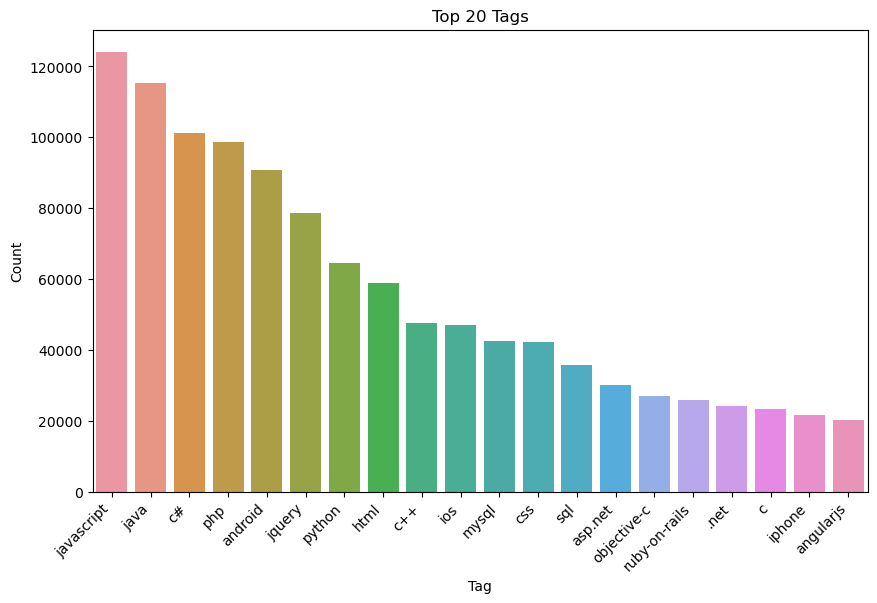

In [ ]:
tags_count = Counter(list(final_df['Tag']))
print("The most frequent Tags are: ")
print(tags_count.most_common(20))

# Create count plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(dict(tags_count.most_common(20)).keys()), y=list(dict(tags_count.most_common(20)).values()))
plt.title('Top 20 Tags')
plt.xlabel('Tag')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

<h2><b>5. Data Cleaning & Preprocessing</b></h2>

<ol>
    <li> Sample 100K data points </li>
    <li> Separate out code-snippets from Body </li>
    <li> Remove Spcial characters from Question title and description (not in code)</li>
    <li> Remove HTML Tags </li>
</ol>

In [ ]:
final_df[final_df['Tag'].isnull()]

,Id,Title,Body,Tag
947,32280,Passing null to a method,<p>I am in the middle of reading the excellent...,NaN
4755,140030,Possible causes of Java VM EXCEPTION_ACCESS_VI...,<p>When a Java VM crashes with an EXCEPTION_AC...,NaN
6892,191640,Get null == null in SQL,<p>I wish to search a database table on a null...,NaN
11107,283190,Asp.net Date Binding Issue with Nulls,<p>I have a nullable date in my database. I am...,NaN
11570,291340,Mark parameters as NOT nullable in C#/.NET?,<p>Is there a simple attribute or data contrac...,NaN
...,...,...,...,...
3722203,39916800,PreventDefault on null value,<p>i am using this code to select an row(id) f...,NaN
3726905,39953580,unittest getDayInWeek return null,<p>I have to test the getDayinWeek method on t...,NaN
3729127,39970580,Ruby 100 doors returning 100 nil,"<p>I'm solving the <a href=""https://www.rosett...",NaN
3731869,39992410,Getting an SQL Exception 'NaN' is not a valid ...,<p>I'm having an SQL exception while i'm tryin...,NaN


In [ ]:
final_df['Tag'] = final_df['Tag'].fillna('no_tag')

In [ ]:
final_df.isnull().sum()

Id       0
Title    0
Body     0
Tag      0
dtype: int64

In [ ]:
final_df[final_df['Tag']=='no_tag']

,Id,Title,Body,Tag
947,32280,Passing null to a method,<p>I am in the middle of reading the excellent...,no_tag
4755,140030,Possible causes of Java VM EXCEPTION_ACCESS_VI...,<p>When a Java VM crashes with an EXCEPTION_AC...,no_tag
6892,191640,Get null == null in SQL,<p>I wish to search a database table on a null...,no_tag
11107,283190,Asp.net Date Binding Issue with Nulls,<p>I have a nullable date in my database. I am...,no_tag
11570,291340,Mark parameters as NOT nullable in C#/.NET?,<p>Is there a simple attribute or data contrac...,no_tag
...,...,...,...,...
3722203,39916800,PreventDefault on null value,<p>i am using this code to select an row(id) f...,no_tag
3726905,39953580,unittest getDayInWeek return null,<p>I have to test the getDayinWeek method on t...,no_tag
3729127,39970580,Ruby 100 doors returning 100 nil,"<p>I'm solving the <a href=""https://www.rosett...",no_tag
3731869,39992410,Getting an SQL Exception 'NaN' is not a valid ...,<p>I'm having an SQL exception while i'm tryin...,no_tag


**Sampling and do feature engineering**

In [ ]:
# Sample 10k data points randomly
sampled_df = final_df.sample(n=100000, random_state=42)  # Adjust the random_state as needed for reproducibility

# Reset the index
sampled_df.reset_index(drop=True, inplace=True)

print(f"The Shape of this sampled dataset is : {sampled_df.shape}")

# Display the sampled DataFrame
sampled_df.head()

The Shape of this sampled dataset is : (100000, 4)


,Id,Title,Body,Tag
0,37815740,cannot connect to sql server with vba runtime ...,i am trying to connect to my sql database and ...,vba
1,36176730,check if csv headers match if they match conti...,i am currently trying to add some validation o...,csv
2,7515640,tableview sections rows and coredata rows are...,i am saving data in coredata to show it in a t...,row
3,29193290,jquery onclick if else if else not working cor...,hi i am running an a jquery function to send s...,jquery
4,9902310,how to insert data in database using checkboxes,im trying to insert data into the database usi...,sqlite


In [ ]:
sampled_df.isnull().sum()

Id       0
Title    0
Body     0
Tag      0
dtype: int64

In [ ]:
print(f"Unique Tags are : {sampled_df['Tag'].unique()}")
print(f"The total no of unique tags : {len(sampled_df['Tag'].unique())}")

Unique Tags are : ['vba' 'csv' 'row' ... 'window.location' 'canvas-lms' 'flexlm']
The total no of unique tags : 11104


The most frequent Tags are: 
[('javascript', 3307), ('java', 2964), ('c#', 2732), ('php', 2655), ('android', 2381), ('jquery', 2104), ('python', 1661), ('html', 1583), ('ios', 1293), ('c++', 1241), ('css', 1152), ('mysql', 1099), ('sql', 963), ('asp.net', 778), ('objective-c', 736), ('.net', 680), ('ruby-on-rails', 673), ('c', 593), ('iphone', 593), ('angularjs', 517), ('arrays', 506), ('json', 477), ('ruby', 470), ('sql-server', 467), ('node.js', 420), ('r', 418), ('ajax', 409), ('regex', 405), ('asp.net-mvc', 395), ('xml', 379)]


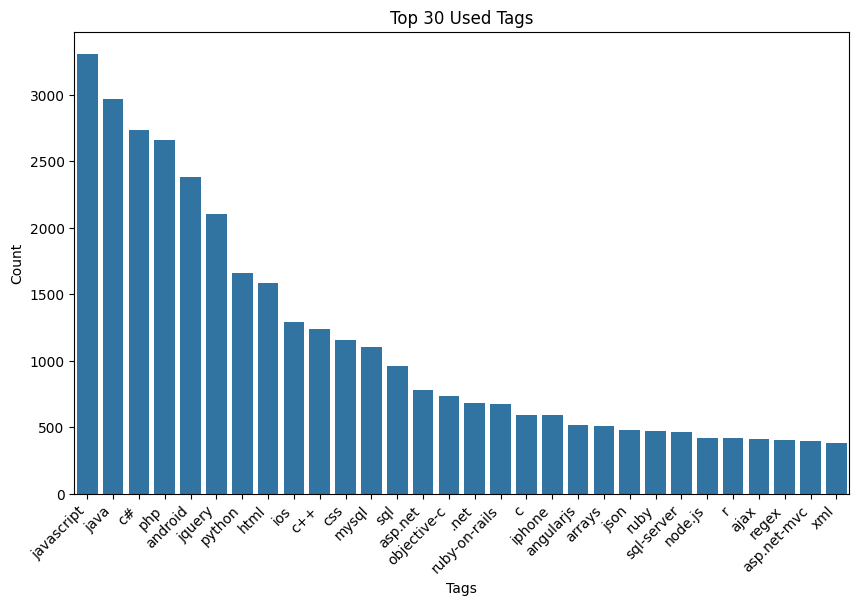

In [13]:
tags_count = Counter(list(sampled_df['Tag']))
print("The most frequent Tags are: ")
print(tags_count.most_common(30))

# Create count plot
plt.figure(figsize=(10, 6))
sns.barplot(x=list(dict(tags_count.most_common(30)).keys()), y=list(dict(tags_count.most_common(30)).values()))
plt.title('Top 30 Used Tags')
plt.xlabel('Tags')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.show()

In [ ]:
# Define a function to remove HTML tags and other symbols
def clean_text(text):
    # Convert text to lowercase
    lowercase_text = text.lower()
    # Remove HTML tags
    cleaned_text = re.sub('<[^<]+?>', '', lowercase_text)
    # Remove symbols and other special characters
    cleaned_text = re.sub('[^a-zA-Z0-9\s]', '', cleaned_text)
    return cleaned_text

In [ ]:
# Apply the function to the DataFrame column containing text data
sampled_df['Body'] = sampled_df['Body'].apply(clean_text)  # Replace 'column_name' with the actual column name
sampled_df['Title'] = sampled_df['Title'].apply(clean_text)  # Replace 'column_name' with the actual column name

In [14]:
common_tags = []
for key, value in tags_count.items():
    if value > 50:
        common_tags.append(key)

In [ ]:
(f"The Number of Tags which are repeated more than 50 times is: {len(common_tags)} units")

'The Number of Tags which are repeated more than 50 times is: 262 units'

In [4]:
instructor_embedding_model = INSTRUCTOR('hkunlp/instructor-large')

.gitattributes:   0%|          | 0.00/1.48k [00:00<?, ?B/s]

1_Pooling/config.json:   0%|          | 0.00/270 [00:00<?, ?B/s]

2_Dense/config.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/3.15M [00:00<?, ?B/s]

README.md:   0%|          | 0.00/66.3k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.53k [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/1.34G [00:00<?, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/2.20k [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/792k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/2.42M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/2.41k [00:00<?, ?B/s]

modules.json:   0%|          | 0.00/461 [00:00<?, ?B/s]

load INSTRUCTOR_Transformer
max_seq_length  512


**Separate dataset for Training and Validation of ratio 80:20**

In [ ]:
def create_train_val_dataframe(data, common_unique_tags, train_size = 0.8):
    train_df = pd.DataFrame()
    val_df = pd.DataFrame()

    for tag in common_unique_tags:
        dfk = data.loc[data['Tag']==tag].reset_index(drop=True)

        #split_size(80:20)
        split_index = int(dfk.shape[0] * train_size)
        print(split_index)

        # split train and validation
        df_train_temp = dfk.iloc[:split_index].reset_index(drop=True)
        df_val_temp = dfk.iloc[split_index:].reset_index(drop=True)

        train_df = pd.concat([train_df, df_train_temp], axis=0, ignore_index=True)
        val_df = pd.concat([val_df, df_val_temp], axis=0, ignore_index=True)

        del dfk, df_train_temp, df_val_temp

    return train_df, val_df

In [ ]:
train_df, val_df = create_train_val_dataframe(sampled_df, common_tags)

In [ ]:
print(f"The shape of the train_df: {train_df.shape}")
train_df.head()

The shape of the train_df: (46895, 4)


,Id,Title,Body,Tag
0,37815740,cannot connect to sql server with vba runtime ...,i am trying to connect to my sql database and ...,vba
1,28697150,day and month are reversed,i have a cell with the following content \n\n0...,vba
2,12814810,driving a ms access query in a subform form fr...,i have a subform in datasheet form\n\ni want t...,vba
3,22635500,excel 2007 macro for copying and saving into ...,i am using excel 2007 i have batches of data i...,vba
4,29775070,display second column separated by comma as su...,is there a way to convert the column b with da...,vba


In [ ]:
len(train_df['Tag'].unique())

262

In [ ]:
print(f"The shape of the val_df: {val_df.shape}")
val_df.head()

The shape of the val_df: (11857, 4)


,Id,Title,Body,Tag
0,39215950,vba formula autofill with relative path,im trying to automate an excel spreadsheet the...,vba
1,31588170,select cells in excel based on cell content,im working with excel trying to write a macro ...,vba
2,8110450,checking values,if userform1combobox1value one then\n\n if...,vba
3,22672310,cannot write data into excel from access while...,when i try to write table contents from access...,vba
4,39904550,clearing all hidden cells in a range,very simple question i keep getting error mess...,vba


In [ ]:
len(val_df['Tag'].unique())

262

In [ ]:
train_title_lists = train_df['Title'].values.tolist()
train_body_lists = train_df['Body'].values.tolist()

In [ ]:
val_title_lists = val_df['Title'].values.tolist()
val_body_lists = val_df['Body'].values.tolist()

In [15]:
tags = ', '.join(common_tags)
instruction = f"Represent the given stackoverflow question for the task of predicting tags of given question from ({tags}): "

In [ ]:
print(instruction)

Represent the given stackoverflow question for the task of predicting tags of given question from (vba, csv, jquery, sqlite, sql, css, button, c#, bash, asp.net-mvc, javascript, elasticsearch, windows-phone-8, oop, c, database, python-2.7, post, jquery-mobile, ubuntu, spring-mvc, eclipse, activerecord, python, linux, ms-access, java, tsql, selenium-webdriver, user-interface, android, git, php, datetime, osx, asp.net, node.js, json, .htaccess, loops, spring, tomcat, xamarin, performance, facebook, opencv, vb.net, wpf, cocoa-touch, silverlight, angularjs, hadoop, mysql, xaml, extjs, stored-procedures, express, caching, swing, ios, sql-server-2008, magento, google-chrome, scala, android-intent, sql-server, playframework, ajax, regex, image, multithreading, class, .net, amazon-web-services, xml, mvvm, file-upload, reactjs, knockout.js, c++, model-view-controller, events, delphi, html, qt, matlab, excel, pointers, r, sorting, authentication, maven, jquery-ui, iphone, http, android-fragments

In [10]:
# Function to create the instruction-query corpus
def create_corpus(titles, body_lists, instruction, label):
    corpus = []
    for title, body in zip(titles, body_lists):
        corpus.append([instruction.lower(), title.lower()+' '+body.lower(), label])
    return corpus

In [ ]:
train_corpus = create_corpus(train_title_lists, train_body_lists, instruction, 0)
print(train_corpus[0])
print(f"The shape is: {len(train_corpus)}")

['represent the given stackoverflow question for the task of predicting tags of given question from (vba, csv, jquery, sqlite, sql, css, button, c#, bash, asp.net-mvc, javascript, elasticsearch, windows-phone-8, oop, c, database, python-2.7, post, jquery-mobile, ubuntu, spring-mvc, eclipse, activerecord, python, linux, ms-access, java, tsql, selenium-webdriver, user-interface, android, git, php, datetime, osx, asp.net, node.js, json, .htaccess, loops, spring, tomcat, xamarin, performance, facebook, opencv, vb.net, wpf, cocoa-touch, silverlight, angularjs, hadoop, mysql, xaml, extjs, stored-procedures, express, caching, swing, ios, sql-server-2008, magento, google-chrome, scala, android-intent, sql-server, playframework, ajax, regex, image, multithreading, class, .net, amazon-web-services, xml, mvvm, file-upload, reactjs, knockout.js, c++, model-view-controller, events, delphi, html, qt, matlab, excel, pointers, r, sorting, authentication, maven, jquery-ui, iphone, http, android-fragmen

In [ ]:
val_corpus = create_corpus(val_title_lists, val_body_lists, instruction, 0)
print(val_corpus[0])
print(f"The shape is: {len(val_corpus)}")

['represent the given stackoverflow question for the task of predicting tags of given question from (vba, csv, jquery, sqlite, sql, css, button, c#, bash, asp.net-mvc, javascript, elasticsearch, windows-phone-8, oop, c, database, python-2.7, post, jquery-mobile, ubuntu, spring-mvc, eclipse, activerecord, python, linux, ms-access, java, tsql, selenium-webdriver, user-interface, android, git, php, datetime, osx, asp.net, node.js, json, .htaccess, loops, spring, tomcat, xamarin, performance, facebook, opencv, vb.net, wpf, cocoa-touch, silverlight, angularjs, hadoop, mysql, xaml, extjs, stored-procedures, express, caching, swing, ios, sql-server-2008, magento, google-chrome, scala, android-intent, sql-server, playframework, ajax, regex, image, multithreading, class, .net, amazon-web-services, xml, mvvm, file-upload, reactjs, knockout.js, c++, model-view-controller, events, delphi, html, qt, matlab, excel, pointers, r, sorting, authentication, maven, jquery-ui, iphone, http, android-fragmen

**Convert (Title+Body) text into Vectro using instructorEmbedding**

In [ ]:
train_embedded_corpus = instructor_embedding_model.encode(train_corpus, show_progress_bar=True)

Batches:   0%|          | 0/1466 [00:00<?, ?it/s]

In [ ]:
print(f"The shape of the train_embedded_corpus is: {train_embedded_corpus.shape}")

The shape of the train_embedded_corpus is: (46895, 768)


In [ ]:
val_embedded_corpus = instructor_embedding_model.encode(val_corpus, show_progress_bar=True)

In [ ]:
print(f"The shape of the val_embedded_corpus is: {val_embedded_corpus.shape}")

The shape of the val_embedded_corpus is: (11857, 768)


In [ ]:
# Convert string train_tags to lists
train_tags = [tag.split() for tag in train_df['Tag']]
print(f"The shape of the train_tag is: {len(train_tags)}")

The shape of the train_tag is: 46895


In [53]:
# Convert string val_tags to lists
val_tags = [tag.split() for tag in val_df['Tag']]
print(f"The shape of the val_tag is: {len(val_tags)}")

The shape of the val_tag is: 11857


In [54]:
# Multi-label binarization for tags
mlb = MultiLabelBinarizer()

In [ ]:
train_mlb_tags = mlb.fit_transform(train_tags)
print(f"The shape of the train_mlb_tag is: {train_mlb_tags.shape}")

The shape of the train_mlb_tag is: (46895, 262)


In [ ]:
val_mlb_tags = mlb.fit_transform(val_tags)
print(f"The shape of the val_mlb_tag is: {val_mlb_tags.shape}")

The shape of the val_mlb_tag is: (11857, 262)


<h2><b>6. Model Preparation (ANN)</b></h2>

In [27]:
# Define the input shape
# There are 768 features in the dataset
input_shape=(768,)

# Define the model
ml_model = Sequential()

# Input layer
ml_model.add(Dense(512, activation='relu', input_shape=input_shape))
ml_model.add(Dropout(0.4))
ml_model.add(BatchNormalization())  # Batch normalization

# Hidden layer-1
ml_model.add(Dense(256, activation='relu'))

# Output layer
# There are 262 unique classes/labels
ml_model.add(Dense(262, activation='softmax'))  # Number of classes

# Define the optimizer with the desired learning rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.000001)
loss_function = keras.losses.BinaryCrossentropy()
metrics = keras.metrics.BinaryAccuracy()

# Compile the model
ml_model.compile(loss=loss_function, optimizer=optimizer, metrics=metrics)

# Print a summary of the model architecture
ml_model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_18 (Dense)            (None, 512)               393728    
                                                                 
 dropout_6 (Dropout)         (None, 512)               0         
                                                                 
 batch_normalization_6 (Bat  (None, 512)               2048      
 chNormalization)                                                
                                                                 
 dense_19 (Dense)            (None, 256)               131328    
                                                                 
 dense_20 (Dense)            (None, 262)               67334     
                                                                 
Total params: 594438 (2.27 MB)
Trainable params: 593414 (2.26 MB)
Non-trainable params: 1024 (4.00 KB)
_________________

<h2><b>7. Model Training & Validating</b></h2>

In [28]:
# Train model with validation data
ml_model.fit(train_embedded_corpus, train_mlb_tags, epochs=100, batch_size=32, validation_data=(val_embedded_corpus, val_mlb_tags))

Epoch 1/100
1466/1466 [==============================] - 9s 5ms/step - loss: 0.6858 - binary_accuracy: 0.9962 - val_loss: 0.6905 - val_binary_accuracy: 0.9962
Epoch 2/100
1466/1466 [==============================] - 7s 5ms/step - loss: 0.6473 - binary_accuracy: 0.9962 - val_loss: 0.6854 - val_binary_accuracy: 0.9962
Epoch 3/100
1466/1466 [==============================] - 8s 6ms/step - loss: 0.5931 - binary_accuracy: 0.9962 - val_loss: 0.6804 - val_binary_accuracy: 0.9962
Epoch 4/100
1466/1466 [==============================] - 7s 5ms/step - loss: 0.5350 - binary_accuracy: 0.9962 - val_loss: 0.6727 - val_binary_accuracy: 0.9962
Epoch 5/100
1466/1466 [==============================] - 8s 6ms/step - loss: 0.4810 - binary_accuracy: 0.9962 - val_loss: 0.6607 - val_binary_accuracy: 0.9962
Epoch 6/100
1466/1466 [==============================] - 7s 5ms/step - loss: 0.4315 - binary_accuracy: 0.9962 - val_loss: 0.6457 - val_binary_accuracy: 0.9962
Epoch 7/100
1466/1466 [=======================

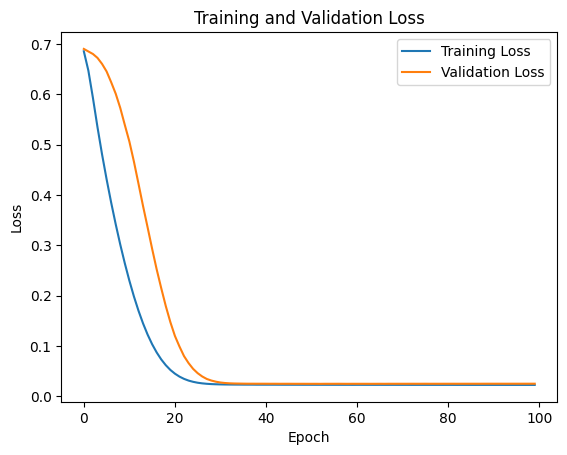

Training Losses: [0.685836672782898, 0.6473398208618164, 0.5930744409561157, 0.5349723696708679, 0.4810348451137543, 0.43145084381103516, 0.385202556848526, 0.34200286865234375, 0.3016113042831421, 0.26425957679748535, 0.22978384792804718, 0.19839856028556824, 0.17011786997318268, 0.14487050473690033, 0.12268620729446411, 0.10342929512262344, 0.08703890442848206, 0.07315485924482346, 0.061716608703136444, 0.052333321422338486, 0.044931042939424515, 0.039065659046173096, 0.03456307202577591, 0.031156618148088455, 0.028704451397061348, 0.026875881478190422, 0.02563926950097084, 0.0247658658772707, 0.02419407293200493, 0.023830080404877663, 0.023572521284222603, 0.023409510031342506, 0.02329941838979721, 0.023216968402266502, 0.023175833746790886, 0.023105720058083534, 0.023084988817572594, 0.02306288667023182, 0.022985784336924553, 0.022991547361016273, 0.02297249063849449, 0.022967353463172913, 0.022947784513235092, 0.02291431650519371, 0.02288622222840786, 0.02288942225277424, 0.022867

In [29]:
# Plot loss graph
plt.plot(ml_model.history.history['loss'], label='Training Loss')
plt.plot(ml_model.history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# Extract training and validation losses
train_losses = ml_model.history.history['loss']
val_losses = ml_model.history.history['val_loss']

# Print training and validation losses
print("Training Losses:", train_losses)
print("Validation Losses:", val_losses)

<h2><b>8. Saving the Trained Model</b></h2>

In [30]:
ml_model.save("/content/drive/MyDrive/StackoverflowQuestionTagging/ml_model_100.h5")

<h2><b>9. Conslusion</b></h2>



*   In conclusion, this notebook presents the development of a predictive model for automating tag prediction on Stack Overflow questions. Leveraging machine learning techniques and a comprehensive dataset comprising question and tag information, we have demonstrated the potential for enhancing searchability and user experience on the platform. Through rigorous experimentation and evaluation, we have established the effectiveness of our model in accurately predicting tags for new questions based on their titles and bodies. Moving forward, the integration of this model into the Stack Overflow platform could streamline question classification and improve searchability, ultimately fostering knowledge sharing and collaboration within the developer community.



<h2><b>10. References</b></h2>

1.   <b>Stackoverflow Overview: </b>  https://www.kaggle.com/code/miljan/predicting-tags-for-stackoverflow/notebook
2.   <b>Research paper: </b> https://arxiv.org/pdf/2212.09741
3.   <b>Instruction Embedding Implementation: </b>
      *   https://pypi.org/project/InstructorEmbedding/
      *   https://github.com/xlang-ai/instructor-embedding
4.   <b>Instruction Embedding Blog: </b> https://instructor-embedding.github.io/